In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch as tch
from torch import nn, Tensor

In [3]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [12, 8]
plt.style.use("dark_background")

In [4]:
dev = tch.device("cuda")
dtype = tch.float32

In [11]:
from genpg.dataset import read_train_data, read_test_data

(train_labels, train_images) = read_train_data()
(test_labels, test_images) = read_test_data()

In [50]:
def make_images(img: np.ndarray) -> Tensor:
    return (tch.from_numpy(img).to(dev) > 127).type(dtype)

In [12]:
from torch.nn.functional import softplus

def normal_log_prob(z_mean: Tensor, z_scale: Tensor):
    "KL-divergence between N(0,1) and N(z_mean,z_scale)"
    z_var = z_scale.pow(2)
    return -0.5 * (1.0 + z_var.log() - z_mean.pow(2) - z_var).mean(1)

def sample_latent(z_distr: Tensor) -> tuple[Tensor, Tensor]:
    "Returns: (z, log_q_z)"

    latent_dim = z_distr.shape[1] // 2
    z_mean, z_scale = z_distr[:, :latent_dim], z_distr[:, latent_dim:]
    z_scale = softplus(z_scale)

    z = z_mean + z_scale * tch.randn_like(z_scale)
    log_q_z = normal_log_prob(z_mean, z_scale)

    return z, log_q_z


In [122]:
from genpg.model import Encoder, Decoder

image_dims = test_images.shape[1:]
hidden_dim = 256
latent_dim = 128

enc = Encoder(image_dims, hidden_dim, 2 * latent_dim).to(dev)
dec = Decoder(latent_dim, hidden_dim, image_dims).to(dev)

In [123]:
batch_size = 128
reg_factor = 1e-1

optim = tch.optim.AdamW(
    list(enc.parameters()) + list(dec.parameters()),
    lr=1e-3,
)

In [124]:
from torch.nn.functional import binary_cross_entropy_with_logits as bce_with_logits
from genpg.dataset import generate_batches
from genpg.utils import Stats
from IPython.display import display, clear_output

for epoch in range(1000):

    enc.train(True)
    dec.train(True)

    train_stats = Stats("reconstruction_loss", "regularization_term", "total_loss")
    for labels, images in generate_batches(batch_size, train_labels, train_images):
        images = make_images(images)

        enc.zero_grad()
        dec.zero_grad()

        x = images
        z_distr = enc.forward(x)
        z, log_q_z = sample_latent(z_distr)
        y = dec.forward(z)

        sim_loss = bce_with_logits(y, x)
        reg_term = log_q_z.mean(0)
        loss = sim_loss + reg_factor * reg_term

        loss.backward()
        optim.step()

        train_stats.append(sim_loss.item(), reg_term.item(), loss.item())

    enc.train(False)
    enc.train(False)

    val_stats = Stats("reconstruction_loss")
    for labels, images in generate_batches(batch_size, test_labels, test_images):
        images = make_images(images)
        
        x = images
        z_distr = enc.forward(x)
        z, log_q_z = sample_latent(z_distr)
        y = dec.forward(z)

        loss = bce_with_logits(y, x)
        val_stats.append(loss.item())
    

    clear_output()
    print(f"{epoch = }")
    display(train_stats.mean())
    display(val_stats.mean())



epoch = 999


{'reconstruction_loss': np.float64(0.6606268849708378),
 'regularization_term': np.float64(0.11759334319690143),
 'total_loss': np.float64(0.6723862197607565)}

{'reconstruction_loss': np.float64(0.6615192490287974)}

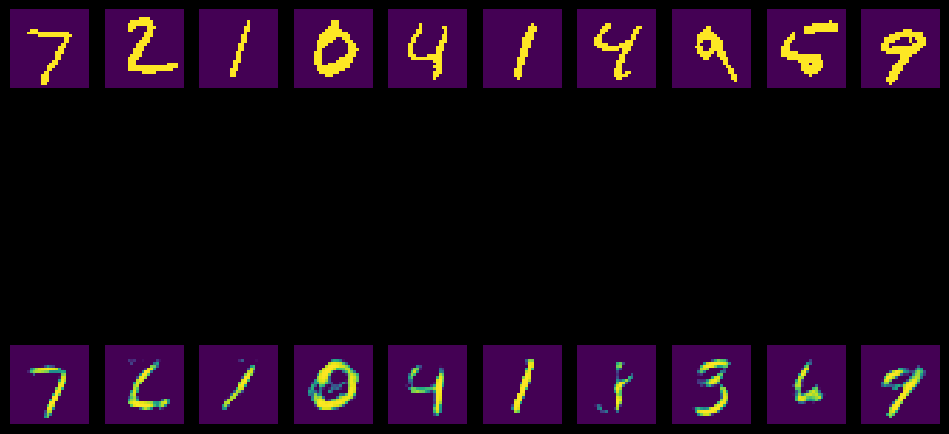

In [125]:
n = 10
x = make_images(test_images[0:n])
z = sample_latent(enc.forward(x))[0]
y = dec.forward(z).sigmoid()

fig, axs = plt.subplots(2, n)
for col, t in enumerate([x, y]):
    img = t.detach().cpu().numpy().clip(0.0, 1.0)
    for row in range(n):
        ax = axs[col, row]
        ax.axis('off')
        ax.imshow(img[row], interpolation='nearest')
fig.show()

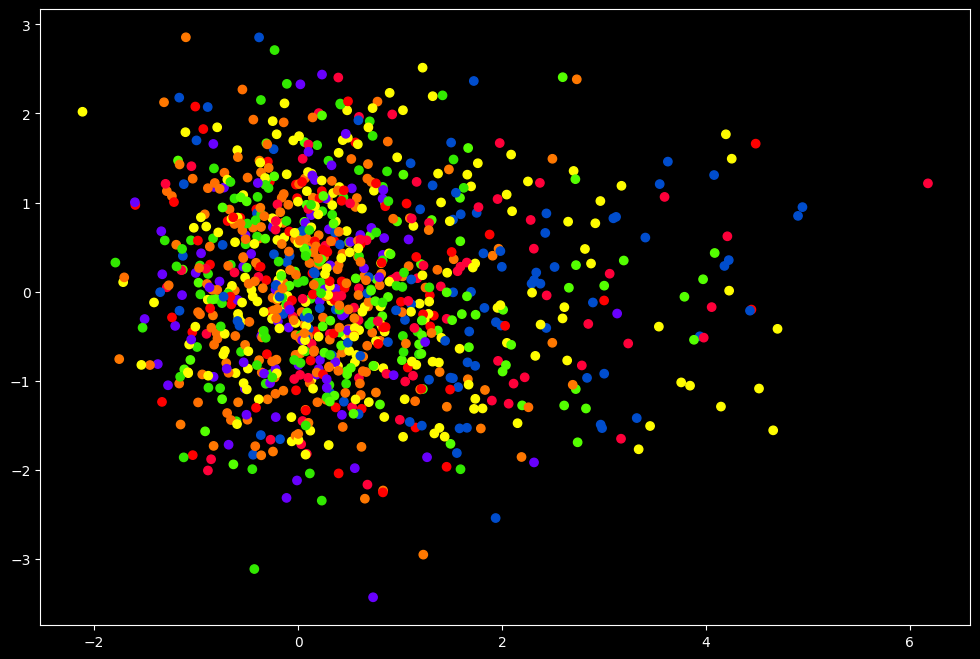

In [126]:
n = 1000
labels = test_labels[:n]
images = make_images(test_images[:n])
z = sample_latent(enc.forward(images))[0].detach().cpu().numpy()
x, y = z[:,0], z[:,1]
plt.scatter(x, y, c=labels, cmap="prism")